# Visualisasi Hasil Analisis Sentimen

Notebook ini membuat visualisasi untuk hasil analisis sentimen:
1. WordCloud per sentimen
2. Distribusi sentimen (Pie & Bar Chart)
3. Elbow Method & Silhouette Score
4. Scatter Plot Clustering (PCA)
5. Confusion Matrix Heatmap

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from PIL import Image
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        pass
sns.set_palette('husl')

# Buat folder output
os.makedirs('output/visualizations', exist_ok=True)
os.makedirs('output/models', exist_ok=True)

In [2]:
# Load data dengan fallback
data_files = [
    'data/hasil_klasifikasi.csv',
    'data/hasil_clustering.csv',
    'data/hasil_preprocessing.csv'
]

df = None
for file in data_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f"Data dimuat dari: {file}")
        break

if df is None:
    raise FileNotFoundError("Tidak ada file data. Jalankan notebook sebelumnya.")

print(f"Jumlah data: {len(df)}")
print(f"Kolom: {df.columns.tolist()}")

Data dimuat dari: data/hasil_klasifikasi.csv
Jumlah data: 4183
Kolom: ['full_text', 'tweet_url', 'original_text', 'cleaned_text', 'preprocessed_text', 'cluster_label', 'sentiment', 'predicted_sentiment']


In [3]:
# Cek kolom yang tersedia
has_sentiment = 'sentiment' in df.columns
has_predicted = 'predicted_sentiment' in df.columns
text_col = 'preprocessed_text' if 'preprocessed_text' in df.columns else 'cleaned_text' if 'cleaned_text' in df.columns else None

print(f"Kolom sentiment: {'Ada' if has_sentiment else 'Tidak ada'}")
print(f"Kolom predicted_sentiment: {'Ada' if has_predicted else 'Tidak ada'}")
print(f"Kolom teks: {text_col}")

Kolom sentiment: Ada
Kolom predicted_sentiment: Ada
Kolom teks: preprocessed_text


## 1. WordCloud per Sentimen

In [4]:
# Import WordCloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("WordCloud tidak tersedia. Install: pip install wordcloud")
    WORDCLOUD_AVAILABLE = False

In [5]:
def generate_wordcloud(text, title, filename, color='viridis'):
    """Generate dan simpan WordCloud dengan fix untuk numpy 2.x"""
    if not WORDCLOUD_AVAILABLE:
        print(f"Skip: {title} (wordcloud tidak tersedia)")
        return
    
    if not text or not text.strip():
        print(f"Skip: {title} (teks kosong)")
        return
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=100,
        min_font_size=10
    ).generate(text)
    
    # Simpan ke file dulu (bypass numpy issue)
    filepath = f'output/visualizations/{filename}'
    wc.to_file(filepath)
    
    # Load sebagai PIL Image dan tampilkan
    img = Image.open(filepath)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(f"Saved: {filepath}")

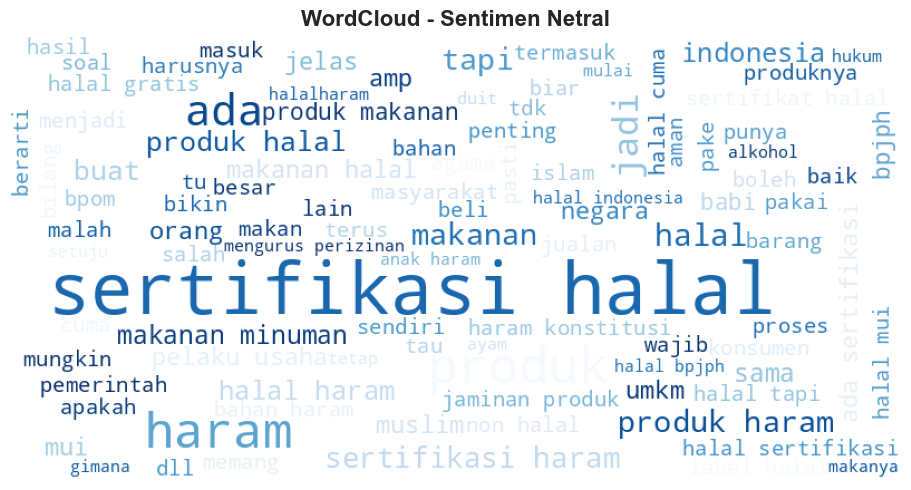

Saved: output/visualizations/wordcloud_netral.png


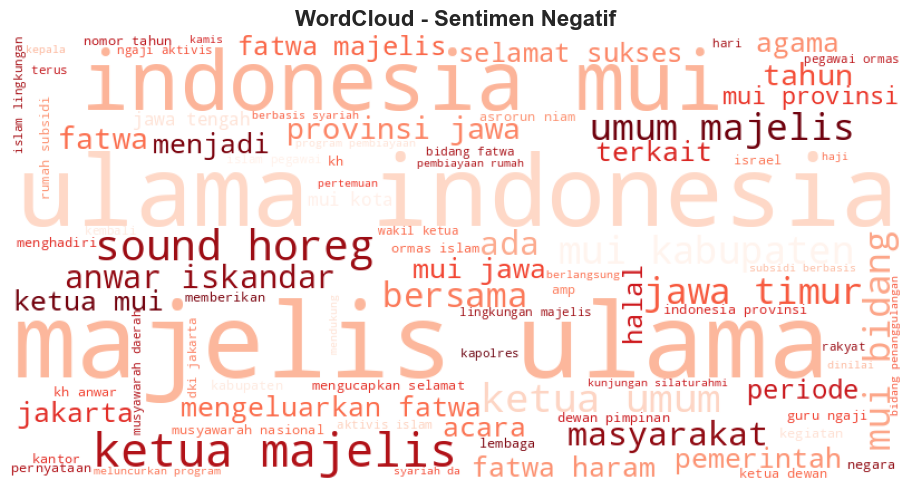

Saved: output/visualizations/wordcloud_negatif.png


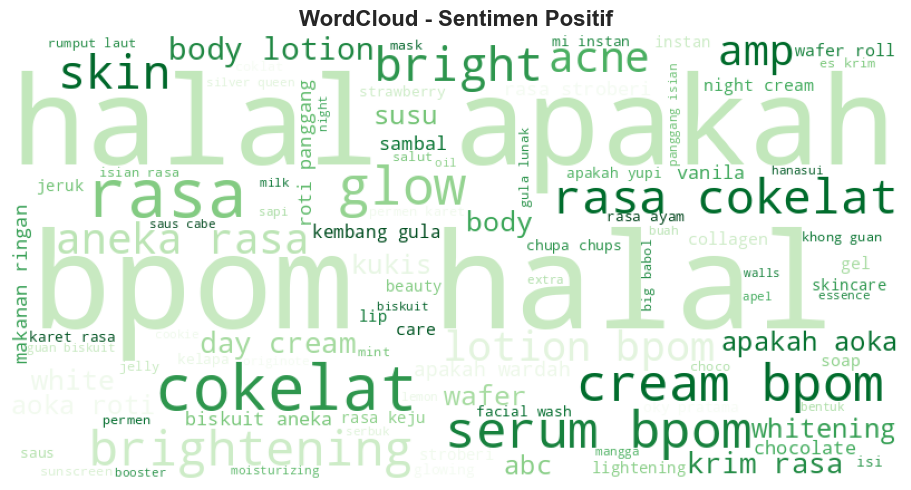

Saved: output/visualizations/wordcloud_positif.png


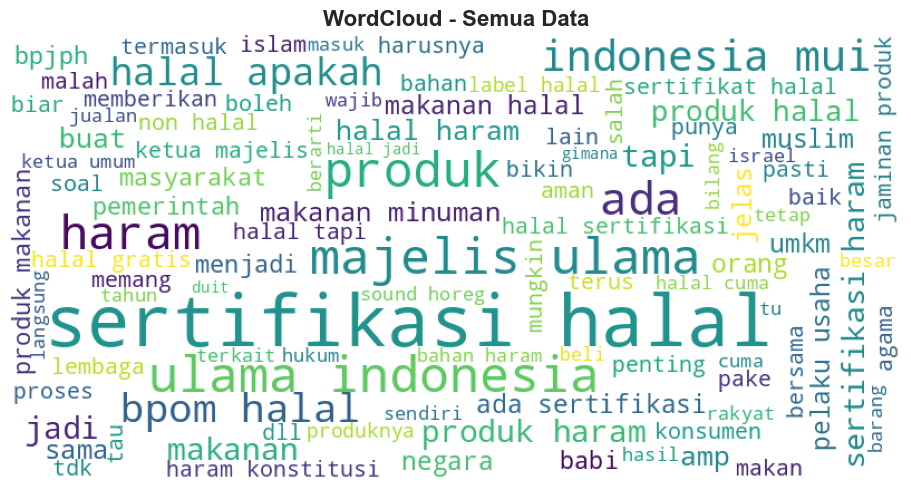

Saved: output/visualizations/wordcloud_all.png


In [6]:
# Generate WordCloud
if text_col and has_sentiment:
    colors = {'positif': 'Greens', 'negatif': 'Reds', 'netral': 'Blues'}
    
    for sentiment in df['sentiment'].unique():
        text = ' '.join(df[df['sentiment'] == sentiment][text_col].dropna().astype(str))
        generate_wordcloud(
            text, 
            f'WordCloud - Sentimen {sentiment.capitalize()}',
            f'wordcloud_{sentiment}.png',
            colors.get(sentiment, 'viridis')
        )
    
    # WordCloud semua data
    all_text = ' '.join(df[text_col].dropna().astype(str))
    generate_wordcloud(all_text, 'WordCloud - Semua Data', 'wordcloud_all.png')
else:
    print("Skip WordCloud: kolom tidak tersedia")

## 2. Distribusi Sentimen

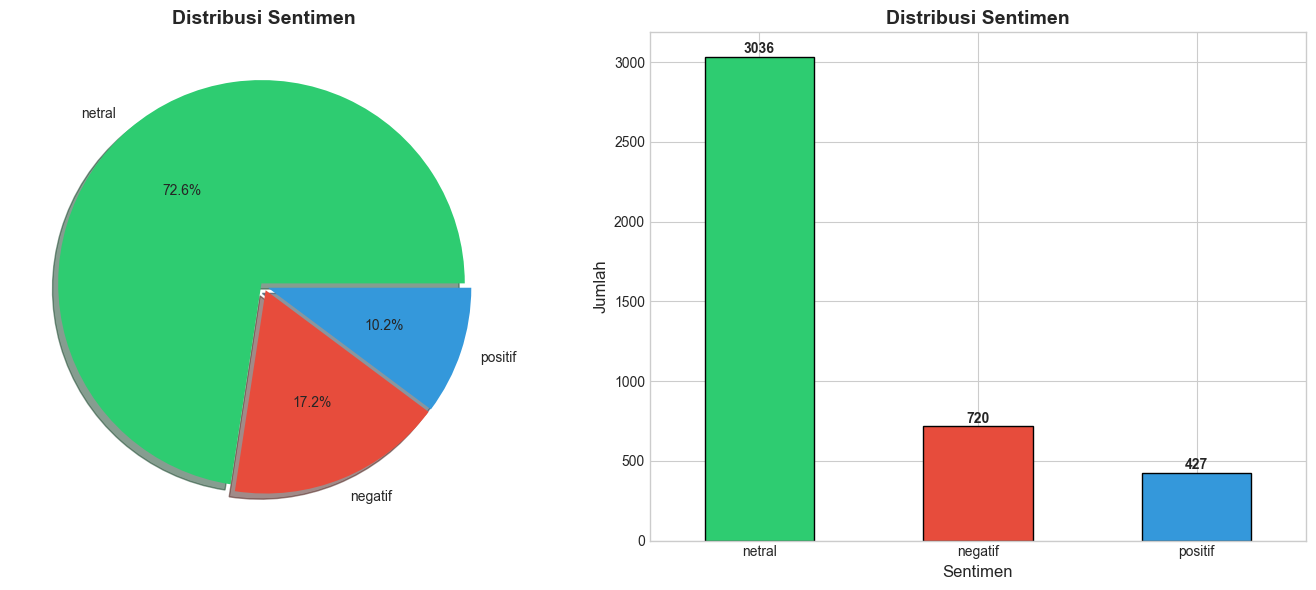

In [7]:
if has_sentiment:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sentiment_counts = df['sentiment'].value_counts()
    colors_pie = ['#2ecc71', '#e74c3c', '#3498db'][:len(sentiment_counts)]
    
    # Pie Chart
    axes[0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
                colors=colors_pie, explode=[0.02]*len(sentiment_counts), shadow=True)
    axes[0].set_title('Distribusi Sentimen', fontsize=14, fontweight='bold')
    
    # Bar Chart
    sentiment_counts.plot(kind='bar', ax=axes[1], color=colors_pie, edgecolor='black')
    axes[1].set_xlabel('Sentimen', fontsize=12)
    axes[1].set_ylabel('Jumlah', fontsize=12)
    axes[1].set_title('Distribusi Sentimen', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=0)
    for i, v in enumerate(sentiment_counts):
        axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('output/visualizations/distribusi_sentimen.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skip: kolom sentiment tidak tersedia")

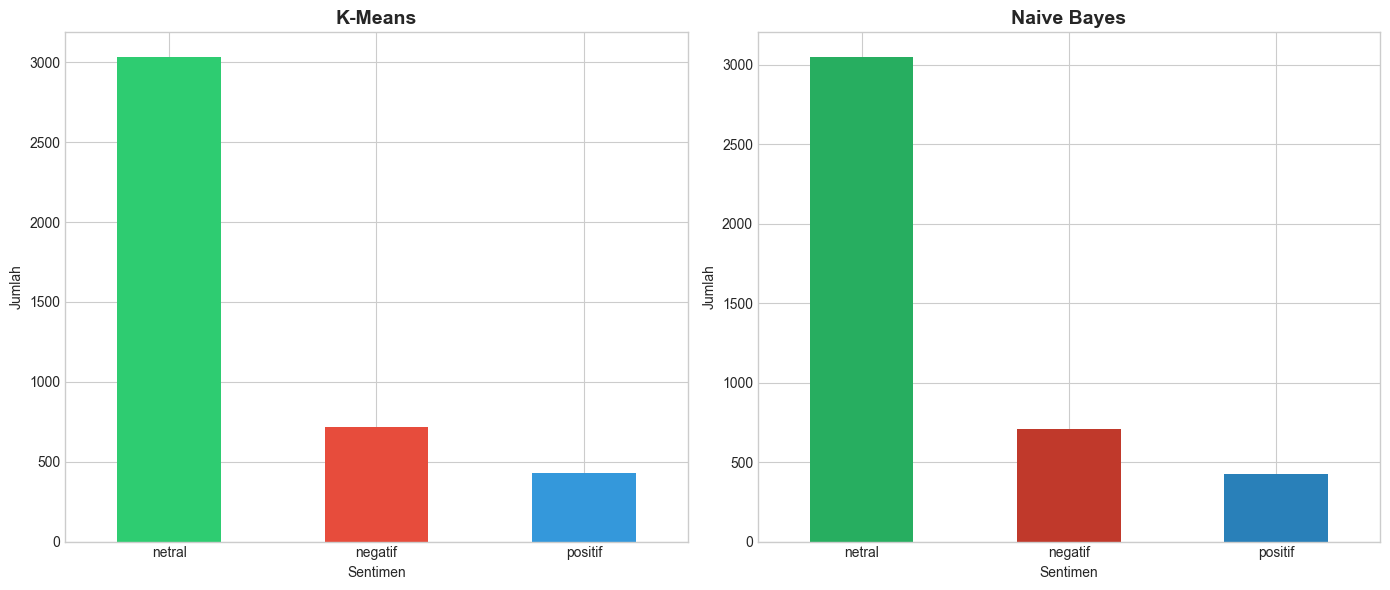

In [8]:
# Perbandingan K-Means vs Naive Bayes
if has_sentiment and has_predicted:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    df['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#3498db'])
    axes[0].set_title('K-Means', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sentimen')
    axes[0].set_ylabel('Jumlah')
    axes[0].tick_params(axis='x', rotation=0)
    
    df['predicted_sentiment'].value_counts().plot(kind='bar', ax=axes[1], color=['#27ae60', '#c0392b', '#2980b9'])
    axes[1].set_title('Naive Bayes', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sentimen')
    axes[1].set_ylabel('Jumlah')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig('output/visualizations/perbandingan_kmeans_nb.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skip perbandingan: kolom tidak lengkap")

## 3. Elbow Method & Silhouette Score

In [9]:
# Load atau buat TF-IDF matrix
tfidf_matrix = None

if os.path.exists('output/models/tfidf_matrix.npz'):
    tfidf_matrix = sparse.load_npz('output/models/tfidf_matrix.npz')
    print(f"TF-IDF dimuat, shape: {tfidf_matrix.shape}")
elif text_col:
    print("Membuat TF-IDF matrix...")
    vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.95)
    tfidf_matrix = vectorizer.fit_transform(df[text_col].fillna(''))
    print(f"TF-IDF dibuat, shape: {tfidf_matrix.shape}")
else:
    print("Tidak dapat membuat TF-IDF")

TF-IDF dimuat, shape: (4183, 1000)


Menghitung...
  k=2: Inertia=3889, Silhouette=0.0306
  k=3: Inertia=3802, Silhouette=0.0391
  k=4: Inertia=3760, Silhouette=0.0388
  k=5: Inertia=3731, Silhouette=0.0389
  k=6: Inertia=3710, Silhouette=0.0375
  k=7: Inertia=3692, Silhouette=0.0380
  k=8: Inertia=3676, Silhouette=0.0374
  k=9: Inertia=3654, Silhouette=0.0389
  k=10: Inertia=3648, Silhouette=0.0298


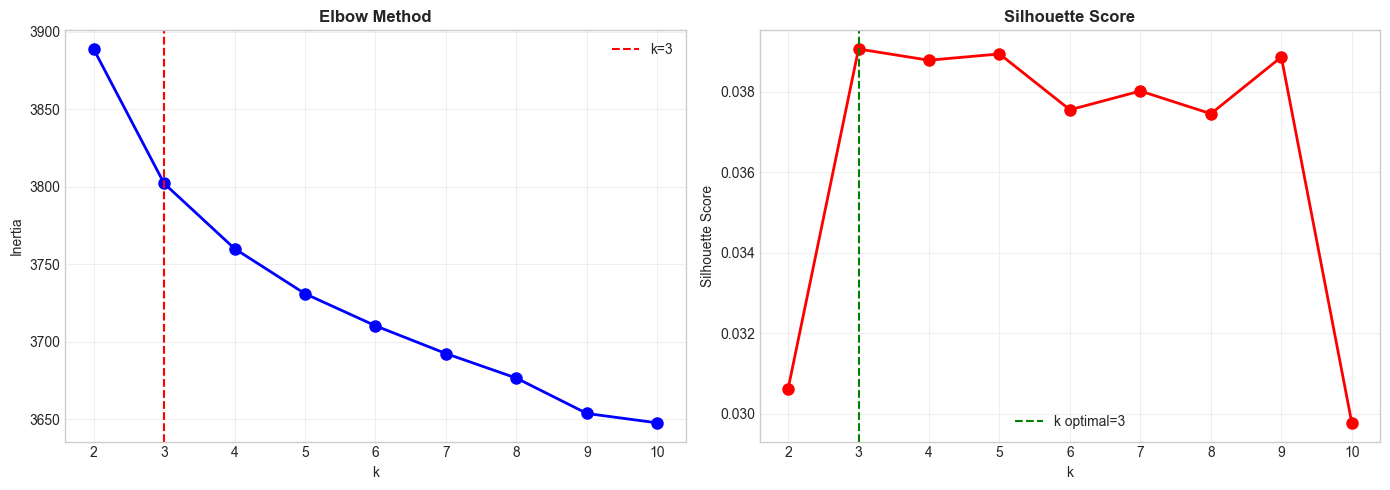

In [10]:
if tfidf_matrix is not None:
    k_range = range(2, 11)
    inertias = []
    sil_scores = []
    
    print("Menghitung...")
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(tfidf_matrix)
        inertias.append(km.inertia_)
        sil_scores.append(silhouette_score(tfidf_matrix, km.labels_))
        print(f"  k={k}: Inertia={km.inertia_:.0f}, Silhouette={sil_scores[-1]:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].axvline(x=3, color='r', linestyle='--', label='k=3')
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    best_k = k_range[np.argmax(sil_scores)]
    axes[1].plot(k_range, sil_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].axvline(x=best_k, color='g', linestyle='--', label=f'k optimal={best_k}')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/visualizations/elbow_silhouette.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Scatter Plot PCA

Explained variance: 6.32%


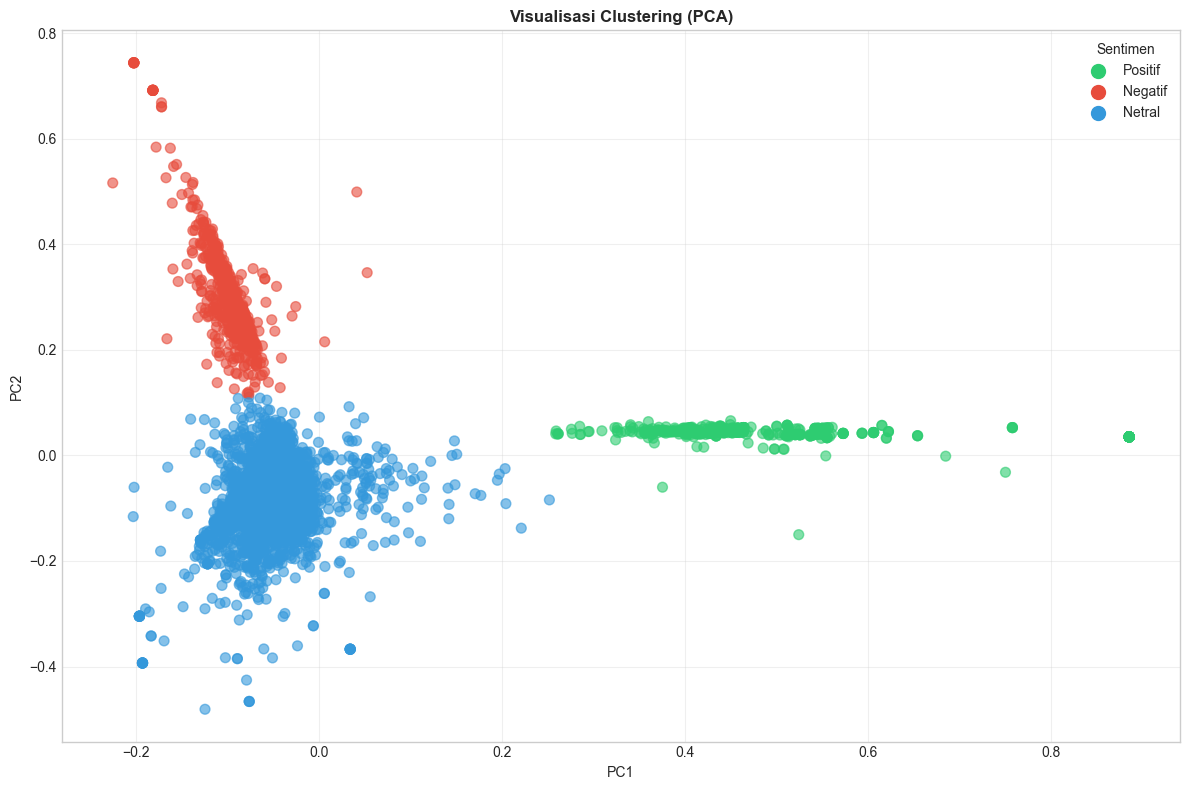

In [11]:
if tfidf_matrix is not None and has_sentiment:
    pca = PCA(n_components=2, random_state=42)
    tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
    print(f"Explained variance: {sum(pca.explained_variance_ratio_):.2%}")
    
    plt.figure(figsize=(12, 8))
    color_map = {'positif': '#2ecc71', 'negatif': '#e74c3c', 'netral': '#3498db'}
    colors = df['sentiment'].map(color_map)
    
    plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=colors, alpha=0.6, s=50)
    
    for sent, col in color_map.items():
        if sent in df['sentiment'].values:
            plt.scatter([], [], c=col, label=sent.capitalize(), s=100)
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Visualisasi Clustering (PCA)', fontweight='bold')
    plt.legend(title='Sentimen')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/visualizations/scatter_pca.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Confusion Matrix

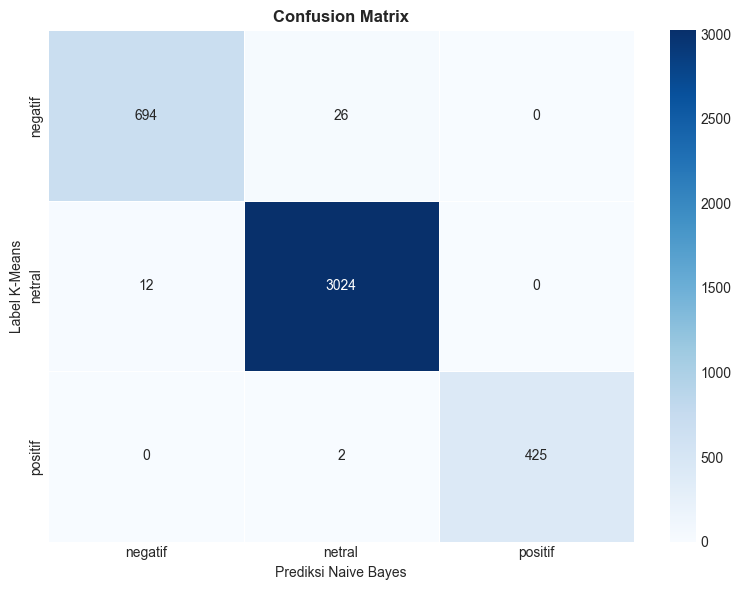

In [12]:
if has_sentiment and has_predicted:
    cm = confusion_matrix(df['sentiment'], df['predicted_sentiment'])
    labels = sorted(df['sentiment'].unique())
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel('Prediksi Naive Bayes')
    plt.ylabel('Label K-Means')
    plt.title('Confusion Matrix', fontweight='bold')
    plt.tight_layout()
    plt.savefig('output/visualizations/confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Statistik Tambahan

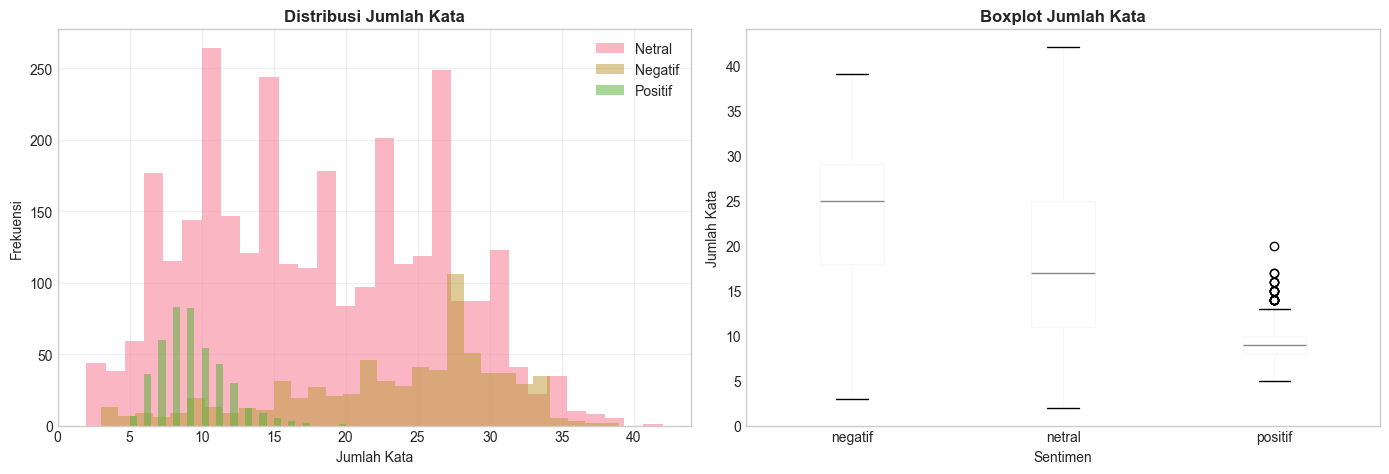

In [13]:
if text_col and has_sentiment:
    df['word_count'] = df[text_col].fillna('').str.split().str.len()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    for sent in df['sentiment'].unique():
        axes[0].hist(df[df['sentiment'] == sent]['word_count'], bins=30, alpha=0.5, label=sent.capitalize())
    axes[0].set_xlabel('Jumlah Kata')
    axes[0].set_ylabel('Frekuensi')
    axes[0].set_title('Distribusi Jumlah Kata', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Boxplot
    df.boxplot(column='word_count', by='sentiment', ax=axes[1], grid=False)
    axes[1].set_xlabel('Sentimen')
    axes[1].set_ylabel('Jumlah Kata')
    axes[1].set_title('Boxplot Jumlah Kata', fontweight='bold')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.savefig('output/visualizations/statistik_kata.png', dpi=150, bbox_inches='tight')
    plt.show()

## Ringkasan

In [14]:
if os.path.exists('output/visualizations'):
    files = sorted(os.listdir('output/visualizations'))
    print(f"File visualisasi ({len(files)}):")
    for f in files:
        print(f"  - {f}")

File visualisasi (10):
  - confusion_matrix.png
  - distribusi_sentimen.png
  - elbow_silhouette.png
  - perbandingan_kmeans_nb.png
  - scatter_pca.png
  - statistik_kata.png
  - wordcloud_all.png
  - wordcloud_negatif.png
  - wordcloud_netral.png
  - wordcloud_positif.png
